Data Source: [ProPublica](https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers)

In [1]:
import pandas as pd

In [2]:
import numpy as np
from numpy import exp, log

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()
sns.set()

In [4]:
from functools import partial

In [5]:
df = pd.read_csv('allegations_20200726939.csv')

In [6]:
df.sample(5, random_state = 42)

,unique_mos_id,first_name,last_name,command_now,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
1288,11229,Michal,Jalbrzykowski,090 PCT,40368,9,2018,7,2019,090 PCT,...,32,Black,Male,32.0,Discourtesy,Word,90.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline B)
29399,6004,John,Gogarty,050 DET,9934,9,2005,6,2006,046 PCT,...,45,NaN,NaN,NaN,Discourtesy,Word,46.0,Report-gun possession/shots fired,Arrest - disorderly conduct,Exonerated
26786,36152,Andrew,Valenzano,WARRSEC,17513,2,2009,10,2009,041 PCT,...,34,Hispanic,Male,30.0,Abuse of Authority,Stop,41.0,PD suspected C/V of violation/crime - street,Arrest - other violation/crime,Exonerated
33002,9609,Douglas,Carr,077 DET,8709,1,2005,2,2006,077 PCT,...,31,NaN,NaN,NaN,Abuse of Authority,Question and/or stop,77.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Exonerated
9303,19561,Michael,Greaney,DBQS,21141,7,2010,7,2011,BX IRT,...,25,Hispanic,Male,29.0,Abuse of Authority,Frisk,44.0,PD suspected C/V of violation/crime - street,Summons - other violation/crime,Unsubstantiated


# 1. Complaint Frequency
Note: frequency-0 officers are truncated (do not appear in the dataset)

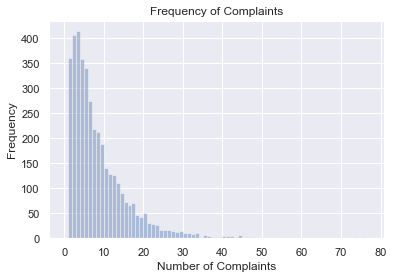

In [7]:
counts = df.unique_mos_id.value_counts()

bins = range(max(counts) + 1 + 2)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = False, kde = False, bins = bins, ax = ax)
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')
plt.show()

## 1a. Zero–Truncated Poisson Distribution

The simplest hypothesis is that every officer has an equal probability of having a complaint lodged against them, per unit time. This would leave to a Poisson distribution with PMF

$$f(k;\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}\$$

However, we do not observe officers with 0 complaints. This leads to a [Zero-Truncated Poisson](https://en.wikipedia.org/wiki/Zero-truncated_Poisson_distribution) distribution with PMF

$$g(k; \lambda) = P_f(k | k > 0) = \frac{f(k; \lambda)}{1 - f(0; \lambda)} = \frac{\lambda^k e^{-\lambda}}{k! ( 1 - e^{-\lambda} )} = \frac{\lambda ^ k}{k!(e^\lambda - 1)}$$

and MLE $\hat{\lambda}$ satisfying

$$\frac{\hat{\lambda}}{1 - e^{-\lambda}} = \overline{x}$$

Unless $\lambda$ is small, this is close to $\hat{\lambda} = \overline{x}$, the MLE for a regular Poisson distribution.

In [8]:
from scipy.optimize import newton_krylov as newton

class ZeroTruncatedPoisson:

    def __init__(self, lamda = None):
      self.lamda = lamda
      self.data = None
    
    def fit(self, data):
      '''Fit to count data
      
      Parameters
      ----------
      
      Data: a numpy Series with counts
      '''
      
      self.data  = data
      self.x_bar = data.mean()
      self.n     = len(data)
      
      def mle_eqn(lamda):
        return lamda / (1 - exp(-lamda)) - self.x_bar
      
      [self.lamda] = newton(mle_eqn, [self.x_bar])
      
    def is_fit(self):
      return self.data is not None
      
    def log_pmf(self, k):
      terms = (
        [-log(m) for m in range(1, k+1)] # 1/k!
       +[k * log(self.lamda), -log(exp(self.lamda) - 1)]
      )
      
      return sum(terms)
      
    def pmf(self, k):
      return exp(self.log_pmf(k))
    
    def log_likelihood(self, data = None):
      '''Log likelihood on a per-observation basis'''
      
      if data is None:
        data = self.data
      
      return self.data.map(self.log_pmf).mean()
    
    def plot(self, max_count = None, include_zero = False, normalize = False):
      '''Returns x and y coordinates for plotting the pmf.
      
      Parameters
      ----------
      
      max_count: maximum value of x to return. If None, the maximum
                 value in the datset is used
                 
      include_zero: whether to include 0 in the xs
      
      normalize: whether to return a PMF or expected counts (using
                 the size of the data)
      
      '''        
      if max_count is None:
        max_count = self.data.max()
        
      xs = np.arange(start = 0 if include_zero else 1,
                     stop  = max_count + 1)
      
      pmf = np.vectorize(self.pmf)
      
      ys = pmf(xs)
      
      if not normalize:
        ys *= self.n
      
      return xs, ys

In [9]:
model = ZeroTruncatedPoisson()
model.fit(counts)

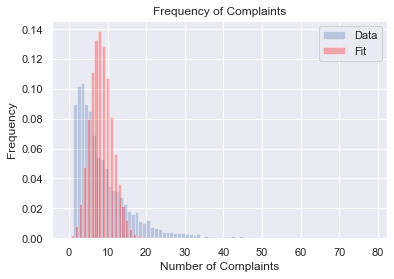

Log Likelihood: -4.739


In [10]:
x_max = max(counts) + 1 + 2
bins = range(x_max)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = True, kde = False, bins = bins, ax = ax, hist_kws = {'alpha' : 0.3, 'label' : 'Data'})
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')

xs, ys = model.plot(max_count = x_max, include_zero = True, normalize = True)

ax.bar(xs, ys, color = 'red', alpha = 0.3, label = 'Fit')
ax.legend();

# It's pretty apparent that the model does not fit the data

plt.show()
print(f'Log Likelihood: {model.log_likelihood():.3f}')

In [11]:
# Compute the Distributions to get the KL-Div

from scipy.special import rel_entr as kl_div

In [12]:
pdfs = counts.value_counts(normalize = True).reset_index().rename({
  'index'         : 'k',
  'unique_mos_id' : 'empirical',
}, axis = 'columns').sort_values('k')

pdfs['zt_poisson'] = pdfs.k.map(model.pmf)

## 1b. The Pareto (Power Law) Distribution

The Pareto Distribution is generated by a process where the "rich get richer" and is the genesis of the "80/20" rule (though the exact numbers may vary) 

In [13]:
from scipy.stats import pareto

In [14]:
b, loc, scale = pareto.fit(counts, floc = 0)
model = pareto(b, loc, scale)
b

/Users/rcharan/anaconda3/envs/synovium/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


0.5756621418416998

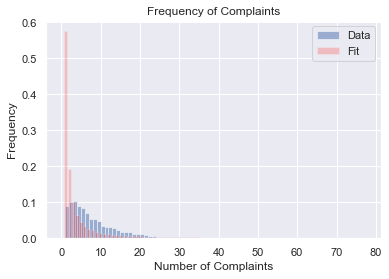

In [15]:
x_max = max(counts) + 1 + 2
bins = range(x_max)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = True, kde = False, bins = bins, ax = ax, hist_kws = {'alpha' : 0.5, 'label' : 'Data'})
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')

xs = np.arange(1, x_max)
ys = model.pdf(xs)

ax.bar(xs, ys, color = 'red', alpha = 0.2, label = 'Fit')
ax.legend();

plt.show()

In [16]:
def logpmf(model, k):
  return log(model.cdf(k+1) - model.cdf(k))

pareto_logpmf = partial(logpmf, model)
log_likelihood = counts.map(pareto_logpmf).mean()

In [17]:
print(f'Log Likelihood: {log_likelihood:.3f}')

Log Likelihood: -3.463


In [18]:
pdfs['pareto'] = pdfs.k.map(lambda k : exp(pareto_logpmf(k)))

# 1c. Negative Binomial Model

Modeling the number of failures before a success in Bernoulli trials. In this context, the theory that with probability $p$ an officer will be reprimanded sufficiently to stop receiving further complaints, and that this will occur $r$ complaints.

Later modeling will take the outcome measure into account.

In [19]:
from scipy.stats import nbinom
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize

In [20]:
def log_likelihood_nbinom(counts, r, p, loc):
  model = nbinom(r, p, loc = loc)
  log_likelihood = model.logpmf(counts)
  return -log_likelihood.sum()

In [21]:
log_likelihood = lambda params : log_likelihood_nbinom(counts, *params, 1)

In [22]:
counts.var()

62.06770750725695

In [23]:
# guess with method of moments. But this doesn't work
e_x = counts.mean()
v_x = counts.var()

r = e_x ** 2 / (v_x - e_x)
p = 1 - e_x / v_x
print(r, p)

r, p = 1.3, 0.1 # Nelder-Mead gets us close enough for convergence

1.297221625905947 0.8655041698314406


In [37]:
guess = np.array([1.2, 0.1]) # Using Nelder-Mean
result = minimize(log_likelihood, guess, method = 'tnc')

In [38]:
result

     fun: 12213.55258003504
     jac: array([ 0.0001819 , -0.00400178])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 38
     nit: 9
  status: 1
 success: True
       x: array([1.13902486, 0.13421018])

In [39]:
r, p = result.x

In [40]:
model = nbinom(r, p, loc = 1)

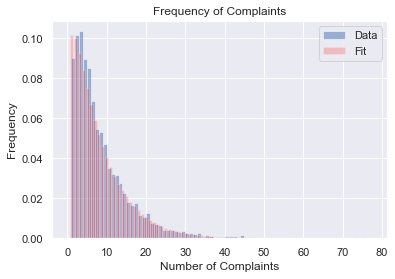

In [41]:
x_max = max(counts) + 1 + 2
bins = range(x_max)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = True, kde = False, bins = bins, ax = ax, hist_kws = {'alpha' : 0.5, 'label' : 'Data'})
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')

xs = np.arange(1, x_max)
ys = model.pmf(xs)

ax.bar(xs, ys, color = 'red', alpha = 0.2, label = 'Fit')
ax.legend();

plt.show()

In [42]:
log_likelihood = counts.map(model.logpmf).mean()
print(f'Log Likelihood: {log_likelihood:.3f}')

Log Likelihood: -3.056


In [43]:
pdfs['nbinom'] = pdfs.k.map(model.pmf)

### 1d: Log Likelihood of the Empirical PMF

In [44]:
log_likelihood = counts.reset_index().merge(
  counts.value_counts(normalize = True).rename('pmf'),
  left_on = 'unique_mos_id',
  right_index = True,
  validate = 'm:1'
)
log_pmf = log(log_likelihood.pmf)

In [45]:
log_pmf.mean()

-3.042101536769978

### 1e: KL-Div

In [46]:
pdfs.columns

Index(['k', 'empirical', 'zt_poisson', 'pareto', 'nbinom'], dtype='object')

In [51]:
model_names = ['zt_poisson', 'pareto', 'nbinom']

divs = map(lambda col : 
     kl_div(pdfs.empirical, pdfs[col]).sum(),
  model_names
)

kl_divs = dict(zip(model_names, divs))

In [53]:
pdfs

,k,empirical,zt_poisson,pareto,nbinom
2,1,0.090090,1.981577e-03,0.329022,0.101514
1,2,0.101602,8.268986e-03,0.139679,0.100109
0,3,0.103604,2.300395e-02,0.081088,0.092698
3,4,0.089840,4.799698e-02,0.054272,0.083976
4,5,0.085085,8.011527e-02,0.039450,0.075233
5,6,0.068819,1.114386e-01,0.030272,0.066947
6,7,0.054555,1.328645e-01,0.024137,0.059305
7,8,0.053303,1.386086e-01,0.019803,0.052365
8,9,0.047297,1.285343e-01,0.016612,0.046125
9,10,0.035035,1.072730e-01,0.014184,0.040552


In [52]:
kl_divs

{'zt_poisson': 1.6968071876952764,
 'pareto': 0.42102483245106875,
 'nbinom': 0.014343052828380254}

# Distributions

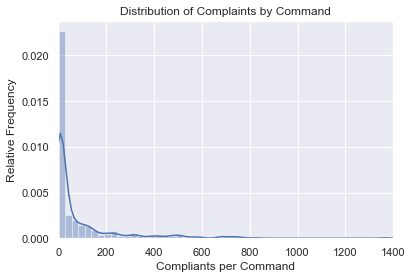

In [31]:
fig, ax = plt.subplots()
sns.distplot(df.command_at_incident.value_counts(), ax = ax)
ax.set_xlim([0, 1400])
ax.set_xlabel('Compliants per Command')
ax.set_ylabel('Relative Frequency')
ax.set_title('Distribution of Complaints by Command')

plt.show()

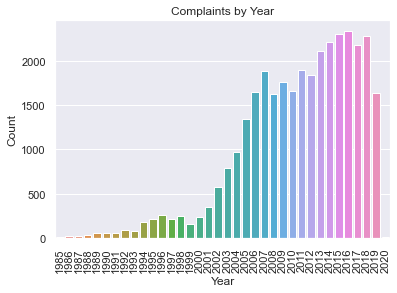

In [43]:
fig, ax = plt.subplots()
sns.barplot(
  x = 'year',
  y = 'count',
    data = df.year_received.value_counts().rename('count').reset_index().rename({
  'index' : 'year'
}, axis = 'columns'),
  ax = ax,
)
plt.xticks(rotation=90)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Complaints by Year')

plt.show()

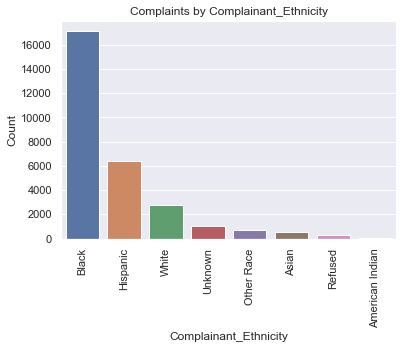

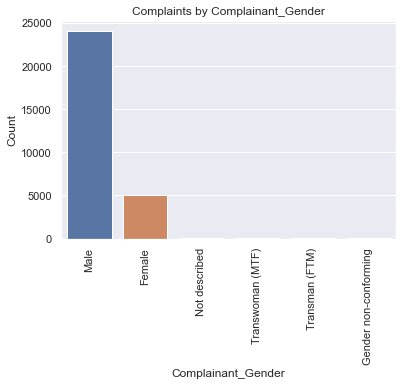

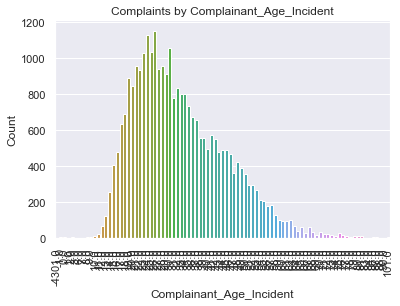

In [49]:
def dist_plot(field):
  fig, ax = plt.subplots()
  sns.barplot(
    x = field,
    y = 'count',
      data = df[field].value_counts().rename('count').reset_index().rename({
    'index' : field
  }, axis = 'columns'),
    ax = ax,
  )
  plt.xticks(rotation=90)
  ax.set_xlabel(field.title())
  ax.set_ylabel('Count')
  ax.set_title(f'Complaints by {field.title()}')

  return fig, ax

dist_plot('complainant_ethnicity')
dist_plot('complainant_gender')
dist_plot('complainant_age_incident')
plt.show()